## 1. Load modules

In [1]:
%load_ext autoreload
%autoreload 2

# Standard library
import os
import sys
import itertools
import warnings
import pandas as pd
from tqdm import tqdm
import threadpoolctl

# Proprietary
from src.methods.other import SLearner 
from src.methods.neural import VCNet, DRNet, CBRNet, MLP 
from sklearn.ensemble import RandomForestRegressor

from src.utils.metrics import (
    mean_integrated_prediction_error,
)
from src.utils.setup import (
    load_config,
    check_create_csv,
    get_rows,
    add_row,
    add_dict,
    dict_to_filename
)
from src.utils.training import cv_tuner
from src.utils.viz import plot_dose_response

from src.optimization.optimizer import optimize_and_track_progress

import logging
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)
logger = logging.getLogger("lightning.pytorch.core")
logger.addHandler(logging.FileHandler("core.log"))
warnings.filterwarnings("ignore")

# set dir
DIR = r"C:\Users\u0148775\PycharmProjects\ICTE"
os.chdir(DIR)
sys.path.append(DIR)

## 2. Settings

In [2]:
# Load settings from config file
config_data = load_config('config/data/config.yaml')
config_methods = load_config('config/methods/config.yaml')
config_optimization = load_config('config/optimization/config.yaml')
config_plot = load_config('config/plot/config.yaml')
config_project = load_config('config/project/config.yaml')

dataset = config_data['data_settings']['dataset']
confounding_bias = config_data['data_settings']['confounding_bias']
HYPERPARAMS = config_methods
optimization_settings_list = config_optimization['optimization_settings_list']
RES_PRED_FILE = config_project['project_settings']['res_pred_file']
TRACKER = config_project['project_settings']['tracker']
RES_OPT_FILE = config_project['project_settings']['res_opt_file']
CONFIG = config_data[dataset]

In [3]:
# Prediction settings

"""
**model_type -- model_name**: Possible combinations
SLearner -- randomf
MLP -- mlp
CBRNet -- cbrnet
DRNet -- drnet
VCNet -- vcnet
"""

model_settings = {
    "model_type": VCNet,
    "model_name": "vcnet", 
    "cost_sensitive_training": False
}
RANDOM_SEARCH_N = 100

combinations = list(itertools.product(*CONFIG.values()))


In [4]:
if dataset == 'ihdp_1':
    from src.data.ihdp_1 import load_data
# add warning that other datasets are not supported
else:
    print("Dataset not supported")
    

## 3. CADR estimation

In [5]:
######################
# 3.1 Prediction Phase
######################

# Initialize the tracker csv file
check_create_csv(TRACKER, CONFIG.keys())

for combination in tqdm(combinations, desc="Iterate over combinations"):
    completed = get_rows(TRACKER)

    if (combination in completed):
        continue

    add_row(TRACKER, combination)
    data_settings = dict(zip(CONFIG.keys(), combination))
    results_predict = {}
    results_predict.update(data_settings)
    data = load_data(bias=confounding_bias, **data_settings)

    # TRAIN MODELS
    name = model_settings["model_name"]  # "randomf", "mlp", "cbrnet", "drnet", "vcnet"
    if name in ["drnet", "vcnet", "mlp", "cbrnet"]:
        HYPERPARAMS[name].update({"input_size": [data.x_train.shape[1]]})

    parameters = HYPERPARAMS[name]

    if name == "randomf":
        parameters.update({"base_model": [RandomForestRegressor]})

    model, best_paras = cv_tuner(
        data=data,
        model=model_settings["model_type"],
        parameters=parameters,
        name=name,
        num_combinations=RANDOM_SEARCH_N,
    )

    results_predict.update(
        {
            "dataset": dataset,
            "confounding_bias": confounding_bias,
            "name": name,
            "cost_sensitive_training": model_settings["cost_sensitive_training"],
            "MISE": mean_integrated_prediction_error(
                x=data.x_test,
                t=data.t_test,
                response=data.ground_truth,
                model=model),
            "best_paras": best_paras
        }
    )

    add_dict(RES_PRED_FILE, results_predict)


Tune vcnet:   0%|          | 0/1 [00:00<?, ?it/s]

Iterate over folds:   0%|          | 0/5 [00:00<?, ?it/s]

Iterate over folds:  20%|██        | 1/5 [00:08<00:34,  8.64s/it]

Iterate over folds:  40%|████      | 2/5 [00:17<00:25,  8.59s/it]

Iterate over folds:  60%|██████    | 3/5 [00:25<00:17,  8.60s/it]

Iterate over folds:  80%|████████  | 4/5 [00:34<00:08,  8.77s/it]

Iterate over folds: 100%|██████████| 5/5 [00:43<00:00,  8.83s/it]

                                                                 
Iterate over combinations: 100%|██████████| 1/1 [00:53<00:00, 53.38s/it]


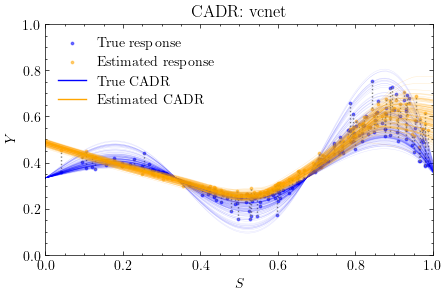

In [6]:
################################
# 3.2. Plot dose-response estimates 
################################

plot_dose_response(data=data,
                   split="test",
                   model=model,
                   name=name,
                   plot_settings=config_plot,
                   optimization_settings=optimization_settings_list,
                   decision_vars=None)

## 4. ... and Optimize

In [7]:
results_optimize, decision_vars = optimize_and_track_progress(
    data=data,
    model=model,
    model_settings=model_settings,
    results_predict=results_predict,
    RES_OPT_FILE=RES_OPT_FILE,
    optimization_settings_list=optimization_settings_list
)


Optimization for 'vcnet'  started. 26 runs.
{'exact': [True], 'cost_sensitive_optimization': [False], 'protected_attribute': [23], 'epsilon_disparate_treatment': [1], 'epsilon_disparate_outcome': [1], 'budget_list': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250], 'ntreatments_list': [10]}


100%|██████████| 26/26 [00:40<00:00,  1.55s/it]
